## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Let's load the MNIST Data

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

Let's Train Autoencoder on this Data

In [3]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])

conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID",
                                activation="selu", input_shape=[3,3,64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME",
                                activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2,padding="SAME",
                                activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
               metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                     validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3018 - rounded_accuracy: 0.9187 - val_loss: 0.2851 - val_rounded_accuracy: 0.9283
Epoch 2/5
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2756 - rounded_accuracy: 0.9413 - val_loss: 0.2729 - val_rounded_accuracy: 0.9458
Epoch 3/5
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2708 - rounded_accuracy: 0.9462 - val_loss: 0.2696 - val_rounded_accuracy: 0.9496
Epoch 4/5
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2682 - rounded_accuracy: 0.9489 - val_loss: 0.2686 - val_rounded_accuracy: 0.9491
Epoch 5/5
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2664 - rounded_accuracy: 0.9509 - val_loss: 0.2673 - val_rounded_accuracy: 0.9505


In [13]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 64)         

In [14]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [15]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

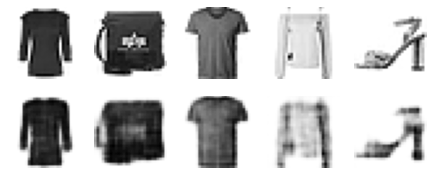

In [16]:
show_reconstructions(conv_ae)
plt.show()

## Without Pretraining

In [17]:
tf.random.set_seed(42)
np.random.seed(42)

X_train_small = X_train[:500]
y_train_small = y_train[:500]

classifier = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size = 3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size = 3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(20, activation="selu"),
    keras.layers.Dense(10, activation="softmax")
])
classifier.compile(loss="sparse_categorical_crossentropy", 
                   optimizer=keras.optimizers.SGD(lr=0.02), metrics = ["accuracy"])

history = classifier.fit(X_train_small, y_train_small, epochs=20,
                         validation_data=(X_valid, y_valid))

Epoch 1/20
16/16 [==============================] - 1s 41ms/step - loss: 2.1818 - accuracy: 0.2720 - val_loss: 1.9776 - val_accuracy: 0.4192
Epoch 2/20
16/16 [==============================] - 0s 22ms/step - loss: 1.7825 - accuracy: 0.5320 - val_loss: 1.6267 - val_accuracy: 0.5346
Epoch 3/20
16/16 [==============================] - 0s 22ms/step - loss: 1.4093 - accuracy: 0.6000 - val_loss: 1.2615 - val_accuracy: 0.6028
Epoch 4/20
16/16 [==============================] - 0s 21ms/step - loss: 1.0873 - accuracy: 0.6880 - val_loss: 1.0040 - val_accuracy: 0.6876
Epoch 5/20
16/16 [==============================] - 0s 22ms/step - loss: 0.9616 - accuracy: 0.6800 - val_loss: 0.9239 - val_accuracy: 0.6928
Epoch 6/20
16/16 [==============================] - 0s 23ms/step - loss: 0.8771 - accuracy: 0.7020 - val_loss: 0.8572 - val_accuracy: 0.7012
Epoch 7/20
16/16 [==============================] - 0s 22ms/step - loss: 0.7733 - accuracy: 0.7540 - val_loss: 0.8086 - val_accuracy: 0.7028
Epoch 8/20
16

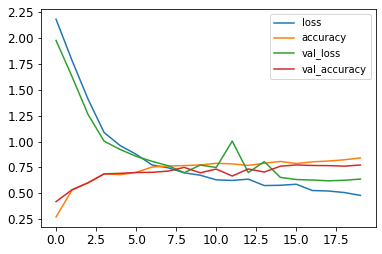

In [18]:
import pandas as pd

pd.DataFrame(history.history).plot()
plt.show()

Using lower layers of trained autoencoder

In [19]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder_clone = keras.models.clone_model(conv_encoder)

pretrained_clf = keras.models.Sequential([
    conv_encoder_clone,
    keras.layers.Flatten(),
    keras.layers.Dense(20, activation="selu"),
    keras.layers.Dense(10, activation="softmax")
])

In [20]:
conv_encoder_clone.trainable = False
pretrained_clf.compile(loss="sparse_categorical_crossentropy",
                      optimizer=keras.optimizers.SGD(lr=0.02),
                      metrics=["accuracy"])

history = pretrained_clf.fit(X_train_small, y_train_small, epochs=30,
                            validation_data=(X_valid, y_valid))

Epoch 1/30
16/16 [==============================] - 0s 30ms/step - loss: 2.3133 - accuracy: 0.1680 - val_loss: 2.2306 - val_accuracy: 0.2382
Epoch 2/30
16/16 [==============================] - 0s 22ms/step - loss: 2.1850 - accuracy: 0.2760 - val_loss: 2.1302 - val_accuracy: 0.3560
Epoch 3/30
16/16 [==============================] - 0s 25ms/step - loss: 2.0876 - accuracy: 0.4000 - val_loss: 2.0362 - val_accuracy: 0.4132
Epoch 4/30
16/16 [==============================] - 0s 23ms/step - loss: 1.9943 - accuracy: 0.4720 - val_loss: 1.9561 - val_accuracy: 0.5152
Epoch 5/30
16/16 [==============================] - 0s 21ms/step - loss: 1.9140 - accuracy: 0.5520 - val_loss: 1.8746 - val_accuracy: 0.5920
Epoch 6/30
16/16 [==============================] - 0s 21ms/step - loss: 1.8325 - accuracy: 0.6400 - val_loss: 1.7987 - val_accuracy: 0.6340
Epoch 7/30
16/16 [==============================] - 0s 22ms/step - loss: 1.7564 - accuracy: 0.6660 - val_loss: 1.7221 - val_accuracy: 0.6414
Epoch 8/30
16

## With Pretraining

In [21]:
conv_encoder_clone.trainable = True

pretrained_clf.compile(loss="sparse_categorical_crossentropy",
                      optimizer=keras.optimizers.SGD(lr=0.02),
                      metrics=["accuracy"])
history = pretrained_clf.fit(X_train_small, y_train_small, epochs=20,
                            validation_data=(X_valid, y_valid))

Epoch 1/20
16/16 [==============================] - 1s 35ms/step - loss: 0.8376 - accuracy: 0.7440 - val_loss: 0.7980 - val_accuracy: 0.7214
Epoch 2/20
16/16 [==============================] - 0s 22ms/step - loss: 0.7373 - accuracy: 0.7660 - val_loss: 0.7892 - val_accuracy: 0.7208
Epoch 3/20
16/16 [==============================] - 0s 23ms/step - loss: 0.7178 - accuracy: 0.7640 - val_loss: 0.7732 - val_accuracy: 0.7088
Epoch 4/20
16/16 [==============================] - 0s 22ms/step - loss: 0.6713 - accuracy: 0.7780 - val_loss: 0.7193 - val_accuracy: 0.7312
Epoch 5/20
16/16 [==============================] - 0s 23ms/step - loss: 0.6546 - accuracy: 0.7620 - val_loss: 0.6884 - val_accuracy: 0.7430
Epoch 6/20
16/16 [==============================] - 0s 23ms/step - loss: 0.6419 - accuracy: 0.7740 - val_loss: 0.7108 - val_accuracy: 0.7298
Epoch 7/20
16/16 [==============================] - 0s 22ms/step - loss: 0.5983 - accuracy: 0.8060 - val_loss: 0.6940 - val_accuracy: 0.7322
Epoch 8/20
16

Due to unsupervised pretraining, the model peformance was increased.